Section 1: Working with the Dataset

In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


In [38]:
DATA_DIR = Path("lnu-butterflies")

train_csv = pd.read_csv(DATA_DIR / "train.csv")
test_csv = pd.read_csv(DATA_DIR / "test.csv")
classes = open(DATA_DIR / "classes.txt").read().splitlines()

train_csv.head(), test_csv.head(), classes[:5]

(                                 id  \
 0  9bb25bc386d6495b9f9ae35f08e7085d   
 1  ecddd57d14c64015b906acde50307a24   
 2  50bdd6a608f04f04bb1d88721442386e   
 3  4e84f59a9a7e42eda7ba4cd6c65efe38   
 4  1fa1f3e8c2c14fe08175bcac63f16b6b   
 
                                                 path               label  
 0  train/EASTERN PINE ELFIN/9bb25bc386d6495b9f9ae...  EASTERN PINE ELFIN  
 1  train/LARGE MARBLE/ecddd57d14c64015b906acde503...        LARGE MARBLE  
 2  train/PAPER KITE/50bdd6a608f04f04bb1d887214423...          PAPER KITE  
 3  train/RED POSTMAN/4e84f59a9a7e42eda7ba4cd6c65e...         RED POSTMAN  
 4  train/GREEN HAIRSTREAK/1fa1f3e8c2c14fe08175bca...    GREEN HAIRSTREAK  ,
                                  id                                       path
 0  4cfe706486ee4561a89188090f52b9c6  test/4cfe706486ee4561a89188090f52b9c6.jpg
 1  2874a810e78844ccbedfb4ae5e54b88a  test/2874a810e78844ccbedfb4ae5e54b88a.jpg
 2  8dd78fedc88644e6baba3642d57049af  test/8dd78fedc88644e6ba

1.3 Basic dataset analysis

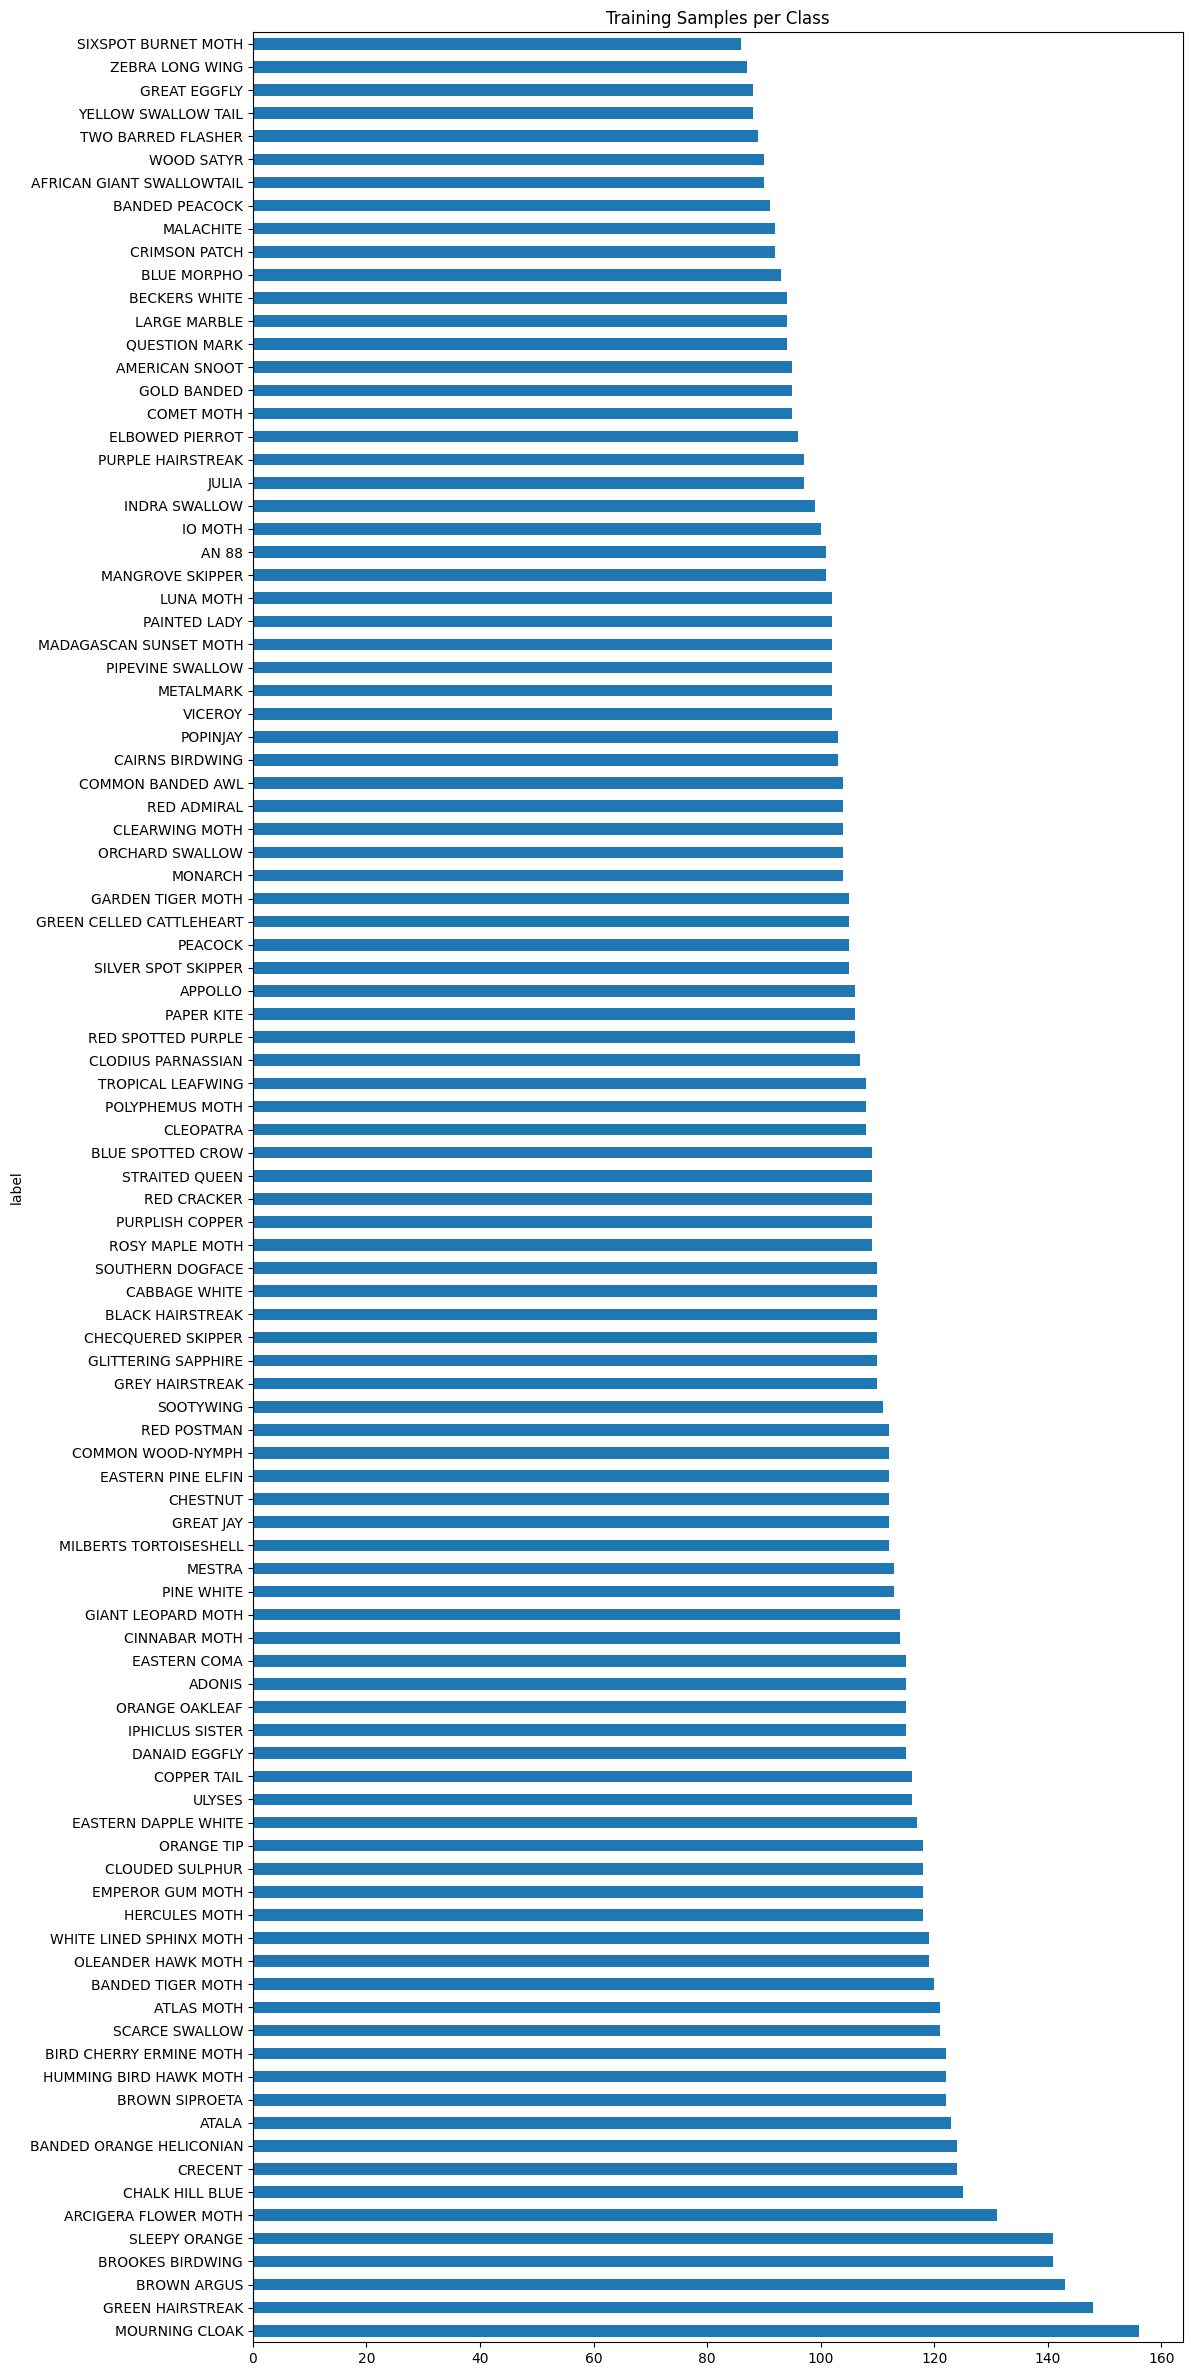

In [39]:
plt.figure(figsize=(12, 30))
train_csv['label'].value_counts().plot(kind='barh')
plt.title("Training Samples per Class")
plt.show()


1.3 Basic dataset analysis

In [40]:
print("Number of classes:", len(classes))
print("Images in train:", len(train_csv))
print("Images in test:", len(test_csv))

Number of classes: 100
Images in train: 10911
Images in test: 2728


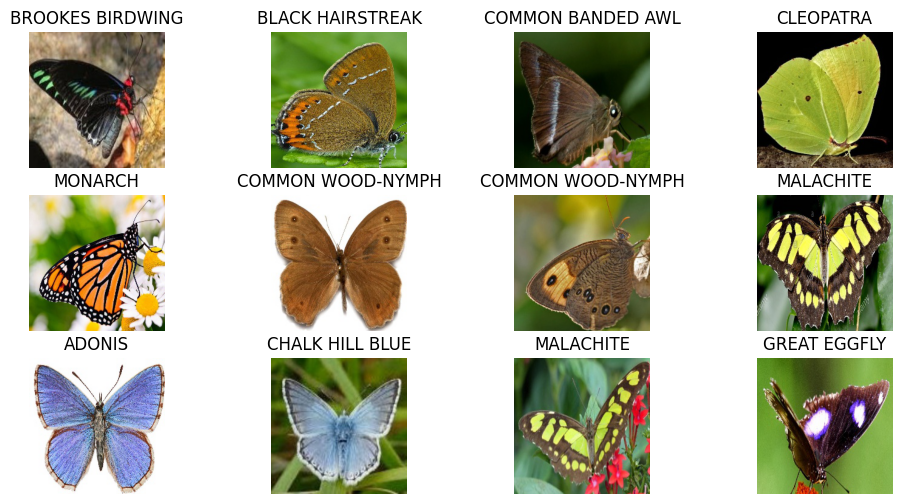

In [41]:
def show_samples(df, n=12):
    plt.figure(figsize=(12, 6))
    subset = df.sample(n)
    for i, (_, row) in enumerate(subset.iterrows()):
        img_path = DATA_DIR / row['path']
        img = Image.open(img_path)
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(row["label"])
    plt.show()

show_samples(train_csv, n=12)

Image shape

Image size: (224, 224)
Mode: RGB


(-0.5, 223.5, 223.5, -0.5)

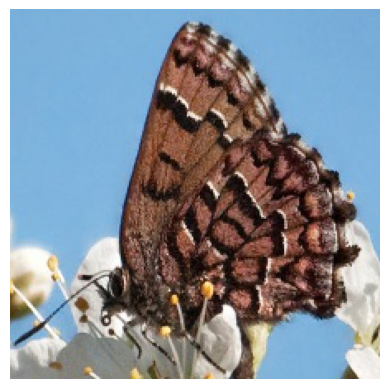

In [42]:
img_path = DATA_DIR / train_csv.iloc[0]['path']
img = Image.open(img_path)
print("Image size:", img.size)
print("Mode:", img.mode)
plt.imshow(img)
plt.axis("off")

Train/Validation Split

In [43]:
from sklearn.model_selection import train_test_split, StratifiedKFold

train_df, val_df = train_test_split(train_csv, test_size=0.1, stratify=train_csv['label'], random_state=42)


Image generation and augmentation

In [44]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

Visualizing augmentations

(-0.5, 223.5, 223.5, -0.5)

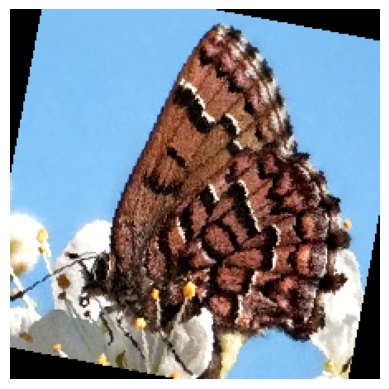

In [45]:
aug_img = train_transform(img)
plt.imshow(aug_img.permute(1, 2, 0))
plt.axis("off")

### Augmentation rationale
- Resize to 224x224 for ImageNet-sized backbones.
- Random flips/rotations/jitter to fight overfitting and class imbalance.
- Keep val transforms simple (resize only) to measure true generalization.


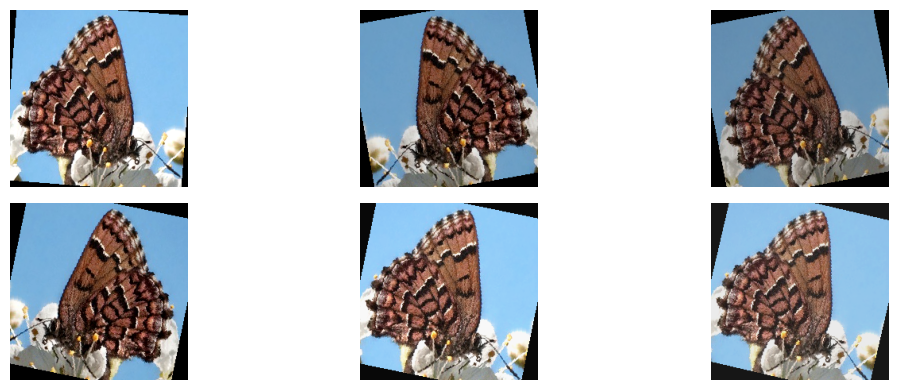

In [46]:
# Visual check: sample several augmented views of the same image
def show_augmented_grid(img, n=6):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        aug = train_transform(img)
        plt.subplot(2, (n+1)//2, i+1)
        plt.imshow(aug.permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()

# uses the `img` loaded earlier
show_augmented_grid(img, n=6)


In [15]:
class ButterflyDataset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(self.root / row["path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = classes.index(row["class"])
        return img, label

train_dataset = ButterflyDataset(train_df, DATA_DIR, train_transform)
val_dataset   = ButterflyDataset(val_df,   DATA_DIR, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)

## Section 2: Training and Comparing Architectures


In [ ]:
from torch.utils.data import Dataset

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

class ButterflyDataset(Dataset):
    def __init__(self, df, root_dir: Path, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.root / row["path"]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_str = row["label"]
        label = classes.index(label_str) 
        return img, label

def get_dataloaders(train_df, val_df, batch_size: int):
    train_dataset = ButterflyDataset(train_df, DATA_DIR, train_transform)
    val_dataset   = ButterflyDataset(val_df,   DATA_DIR, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

train_loader, val_loader = get_dataloaders(train_df, val_df, batch_size=32)

Using device: cuda


In [17]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import timm

num_classes = len(classes)

def build_model(arch: str, num_classes: int):
    arch = arch.lower()
    if arch == "alexnet":
        try:
            weights = models.AlexNet_Weights.IMAGENET1K_V1
            model = models.alexnet(weights=weights)
        except Exception:
            model = models.alexnet(pretrained=True)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features, num_classes)

    elif arch == "resnet18":
        from torchvision.models import resnet18, ResNet18_Weights
        try:
            weights = ResNet18_Weights.IMAGENET1K_V1
            model = resnet18(weights=weights)
        except Exception:
            model = resnet18(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif arch == "convnext_tiny":
        model = timm.create_model(
            "convnext_tiny",
            pretrained=True,
            num_classes=num_classes,
        )

    elif arch == "convnext_base":
        model = timm.create_model(
            "convnext_base",
            pretrained=True,
            num_classes=num_classes,
        )

    else:
        raise ValueError(f"Unknown architecture: {arch}")

    return model.to(DEVICE)

In [18]:
import time

OUT_DIR = Path("models")
OUT_DIR.mkdir(exist_ok=True)

def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs: int,
    lr: float,
    weight_decay: float,
    arch_name: str,
):
    criterion = nn.CrossEntropyLoss()

    if arch_name.startswith("convnext"):
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    else:
        optimizer = optim.SGD(
            model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay
        )
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0
    best_state = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        start = time.time()

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += (preds == labels).sum().item()
            total += images.size(0)

        train_loss = running_loss / total
        train_acc = running_corrects / total

        model.eval()
        v_loss = 0.0
        v_corrects = 0
        v_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                v_loss += loss.item() * images.size(0)
                v_corrects += (preds == labels).sum().item()
                v_total += images.size(0)

        val_loss = v_loss / v_total
        val_acc = v_corrects / v_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(
            f"[{arch_name}] Epoch {epoch+1}/{num_epochs} | "
            f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    return best_state, best_val_acc, history


In [19]:
def run_cross_validation(
    df,
    arch_name: str,
    n_splits: int = 5,
    batch_size: int = 32,
    num_epochs: int = 5,
    lr: float = 1e-4,
    weight_decay: float = 1e-4,
):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label']), start=1):
        print(f"\n===== Fold {fold}/{n_splits} for {arch_name} =====")
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        train_loader, val_loader = get_dataloaders(train_df, val_df, batch_size=batch_size)

        model = build_model(arch_name, num_classes)
        best_state, best_val_acc, history = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            weight_decay=weight_decay,
            arch_name=arch_name,
        )

        fold_results.append({"fold": fold, "best_val_acc": best_val_acc, "history": history})

        torch.save(
            {
                "model_state_dict": best_state,
                "class_to_idx": {c: i for i, c in enumerate(classes)},
                "arch": arch_name,
                "fold": fold,
            },
            OUT_DIR / f"{arch_name}_fold{fold}.pth",
        )

    mean_acc = sum(r['best_val_acc'] for r in fold_results) / len(fold_results)
    print(f"\n{arch_name} mean val acc over {n_splits} folds: {mean_acc:.4f}")
    return fold_results, mean_acc


## Hyperparameter Tuning
Use grid search + cross-validation to compare learning rates, weight decay, batch size, or epochs.

In [21]:
from itertools import product

def grid_search_cv(
    df,
    arch_name: str,
    param_grid: dict,
    n_splits: int = 3,
):
    keys = list(param_grid.keys())
    results = []

    for values in product(*[param_grid[k] for k in keys]):
        params = dict(zip(keys, values))
        print(f"\n>>> {arch_name} params: {params}")
        folds, mean_acc = run_cross_validation(
            df,
            arch_name=arch_name,
            n_splits=n_splits,
            batch_size=params.get("batch_size", 32),
            num_epochs=params.get("num_epochs", 5),
            lr=params.get("lr", 1e-4),
            weight_decay=params.get("weight_decay", 1e-4),
        )
        result = {"arch": arch_name, **params, "mean_acc": mean_acc, "folds": folds}
        results.append(result)

    results = sorted(results, key=lambda x: x["mean_acc"], reverse=True)
    return results


## Section 3: Choosing the models architectures


The first tested model was AlexNet. 

![AlexNet architecture](images/AlexNet.png)

The second was ResNet 18:

![AlexNet architecture](images/ResNet18.png)

The fourth was ConvNext Tiny:

![AlexNet architecture](images/ConvNeXtTiny.png)

The fifth was ConvNext Base:

![AlexNet architecture](images/ConvNeXtBase.png)

## Section 4: K-fold evaluation of saved checkpoints (no retraining)
Use existing checkpoints, run K-fold stratified evaluation on the train set, and report mean accuracy.

In [23]:
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import models
import torch
import torch.nn as nn

try:
    import timm
    TIMM_AVAILABLE = True
except ModuleNotFoundError:
    TIMM_AVAILABLE = False

try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except ModuleNotFoundError:
    YOLO_AVAILABLE = False

warnings.filterwarnings("ignore", category=FutureWarning, message=".*weights_only=False.*")

try:
    num_classes = len(classes)
except NameError:
    num_classes = train_csv["label"].nunique()

class YOLOLogitsWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        out = self.model(x)
        if isinstance(out, tuple):
            return out[0]
        if isinstance(out, list):
            first = out[0]
            return first.logits if hasattr(first, 'logits') else first
        return out

def make_loader(df: pd.DataFrame, batch_size: int = 32):
    ds = ButterflyDataset(df, DATA_DIR, transform=val_transform)
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

def build_model_for_eval(arch: str, num_classes: int):
    arch = arch.lower()
    if arch == "alexnet":
        model = models.alexnet(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif arch == "resnet18":
        from torchvision.models import resnet18
        model = resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif arch in ("convnext_tiny", "convnext_base"):
        if not TIMM_AVAILABLE:
            raise ModuleNotFoundError("timm not available; skipping convnext eval")
        model = timm.create_model(arch, pretrained=False, num_classes=num_classes)
    else:
        raise ValueError(f"Unknown architecture: {arch}")
    return model.to(DEVICE)

def infer_arch_from_filename(fname: str) -> str | None:
    name = fname.lower()
    if "alexnet" in name:
        return "alexnet"
    if "resnet18" in name:
        return "resnet18"
    if "convnext_tiny" in name:
        return "convnext_tiny"
    if "convnext_base" in name or ("convnext" in name and "tiny" not in name):
        return "convnext_base"
    if "yolo" in name:
        return "yolo"
    return None

def load_trained_model(ckpt_path: Path, default_arch: str, num_classes: int):
    if default_arch == 'yolo' and ckpt_path.suffix == '.pt':
        if not YOLO_AVAILABLE:
            raise ModuleNotFoundError("ultralytics not available; skipping yolo eval")
        yolo_model = YOLO(str(ckpt_path)).model.to(DEVICE).eval()
        wrapped = YOLOLogitsWrapper(yolo_model)
        wrapped.eval()
        return wrapped, 'yolo'
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    arch = ckpt.get("arch", ckpt.get("model_name", default_arch))
    model = build_model_for_eval(arch, num_classes)
    model.load_state_dict(ckpt["model_state_dict"], strict=True)
    model.eval()
    return model, arch

def kfold_evaluate_fixed(model, n_splits: int = 3, batch_size: int = 32):
    X = train_csv["path"].values
    y = train_csv["label"].values
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accs = []

    for fold, (_, val_idx) in enumerate(skf.split(X, y), start=1):
        val_df = train_csv.iloc[val_idx]
        loader = make_loader(val_df, batch_size=batch_size)
        all_true, all_pred = [], []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                preds = outputs.argmax(1)
                all_true.append(labels.cpu().numpy())
                all_pred.append(preds.cpu().numpy())
        y_true = np.concatenate(all_true)
        y_pred = np.concatenate(all_pred)
        acc = accuracy_score(y_true, y_pred)
        fold_accs.append(acc)
    mean_acc = float(np.mean(fold_accs))
    return fold_accs, mean_acc

ckpt_dir = Path("models")
extra_ckpts = [p for p in [Path("yolov8s-cls.pt"), Path("yolov8m-cls.pt"), Path("yolo11n.pt")] if p.exists()]
rows = []
for p in list(sorted(ckpt_dir.glob("*.pth"))) + extra_ckpts:
    arch_guess = infer_arch_from_filename(p.name if isinstance(p, Path) else str(p))
    if arch_guess is None:
        print(f"Skipping {p}: cannot infer architecture")
        continue
    if arch_guess.startswith('convnext') and not TIMM_AVAILABLE:
        print(f"Skipping {p}: timm not installed (needed for convnext)")
        continue
    if arch_guess == 'yolo' and not YOLO_AVAILABLE:
        print(f"Skipping {p}: ultralytics not installed")
        continue
    print(f"=== {p.name if isinstance(p, Path) else p} (arch guess: {arch_guess}) ===")
    try:
        model, arch_used = load_trained_model(Path(p), default_arch=arch_guess, num_classes=num_classes)
    except Exception as e:
        print(f"Skipping {p}: {e}")
        continue
    fold_accs, mean_acc = kfold_evaluate_fixed(model, n_splits=3, batch_size=32)
    rows.append({"checkpoint": p.name if isinstance(p, Path) else str(p), "arch": arch_used, "fold_accs": fold_accs, "mean_acc": mean_acc})

kfold_metrics_df = pd.DataFrame(rows).sort_values("mean_acc", ascending=False) if rows else pd.DataFrame()
kfold_metrics_df


=== alexnet_butterflies_best.pth (arch guess: alexnet) ===
=== convnext_base1_butterflies_best.pth (arch guess: convnext_base) ===
=== convnext_butterflies_best.pth (arch guess: convnext_base) ===
=== convnext_tiny_butterflies_best.pth (arch guess: convnext_tiny) ===
=== resnet18_butterflies_best.pth (arch guess: resnet18) ===


,checkpoint,arch,fold_accs,mean_acc
1,convnext_base1_butterflies_best.pth,convnext_base,"[0.9898267803134452, 0.9942260104481716, 0.993...",0.992485
3,convnext_tiny_butterflies_best.pth,convnext_tiny,"[0.9763541380258455, 0.9810283200439923, 0.978...",0.978462
0,alexnet_butterflies_best.pth,alexnet,"[0.951333516634589, 0.9593071212537806, 0.9518...",0.954175
4,resnet18_butterflies_best.pth,resnet18,"[0.9166895793236184, 0.9186142425075612, 0.915...",0.916873
2,convnext_butterflies_best.pth,convnext_tiny,"[0.0761616717074512, 0.07973604619191642, 0.08...",0.078728


## Section 4: Evaluation of Results


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

val_batch_size = 32
_, val_loader = get_dataloaders(train_df, val_df, batch_size=val_batch_size)

BEST_ARCH = "convnext_base"  
BEST_CKPT = Path("models/convnext_base1_butterflies_best.pth")

print("Evaluating checkpoint:", BEST_CKPT)


Evaluating checkpoint: models\convnext_base1_butterflies_best.pth


In [ ]:
def load_best_model(arch_name: str, ckpt_path: Path, num_classes: int):
    checkpoint = torch.load(ckpt_path, map_location=DEVICE)

    arch = checkpoint.get("arch", checkpoint.get("model_name", arch_name))
    print(f"Loaded checkpoint arch: {arch}")

    model = build_model(arch, num_classes)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(DEVICE)
    model.eval()
    return model

best_model = load_best_model(BEST_ARCH, BEST_CKPT, num_classes=len(classes))


Loaded checkpoint arch: convnext_base


In [33]:
all_true = []
all_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy (top-1): {acc:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=classes))


Validation accuracy (top-1): 0.9945

Classification report:
                           precision    recall  f1-score   support

                   ADONIS       1.00      1.00      1.00        12
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         9
           AMERICAN SNOOT       1.00      1.00      1.00         9
                    AN 88       1.00      1.00      1.00        10
                  APPOLLO       1.00      1.00      1.00        11
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00        13
                    ATALA       1.00      1.00      1.00        12
               ATLAS MOTH       1.00      1.00      1.00        12
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00        12
           BANDED PEACOCK       1.00      1.00      1.00         9
        BANDED TIGER MOTH       1.00      1.00      1.00        12
            BECKERS WHITE       1.00      0.89      0.94         9
  BIRD CHERRY ERMINE MOTH       0.92      0.92      0.92        12
 

![Confusion matrix for best model](images/confusion_best_model.png)